# Lazy LazyPredict: An Exercise in Automated Python Libraries

[LazyPredict](https://pypi.org/project/lazypredict/) is an excellent python library that allows the user to automatically run their data through a myriad of models. It will then output information regarding how each model performed, allowing the user to view which model might be best for their use case.

This is a great tool to save time that might otherwise be spent manually testing different models. But while exploring this tool, I began to wonder what other manual steps I could accomplish purely with python libraries. And with that thought, I dove into a test of lazier than lazypredict predictions.

___

## Folder Structure

- Utilized data can be found in the /data folder, retrieved from [Kaggle.com](https://www.kaggle.com/c/titanic/overview)
- All images can be found in the /images folder

## Installing Libraries

Here, I install the requisite libraries to do some EDA (exploratory data analysis) and feature engineering for me.

After all:

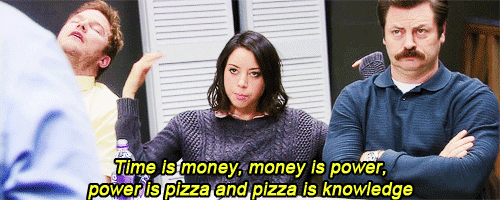

<h5 align = 'center'>
    Image from
    <a href = ' https://giphy.com/gifs/time-money-power-p6iPHyrGYLiRq'>
    Giphy.com
    </a>
</h5>

Uncomment and run the cells below for libraries that you do not currently have.

Note: Some users, particularly Windows, may run into problems with installation. If so, running a command prompt in administrator mode and running the respective code may solve it. Otherwise, please refer to the library's documentation:
- [Lazy Predict](https://pypi.org/project/lazypredict/)
- [Feature Engine](https://pypi.org/project/feature-engine/)
- [Feature Tools](https://pypi.org/project/featuretools/)

In [1]:
#pip install lazypredict

In [2]:
#pip install feature_engine

In [3]:
#pip install featuretools

### Importing Libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import Winsorizer

import featuretools as ft
import featuretools.variable_types as vtypes

from lazypredict.Supervised import LazyClassifier

## Cleaning the Data

In [5]:
#Read in and view the data
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [6]:
#Check for missing values
len(df), df.isna().sum()

(891,
 PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64)

It looks like there are some missing values. Cabin may have too many missing values to impute (687 out of 891), but Age may be something I can work with. Here's where Feature Engine comes in. I'll be using the MeanMedianImputer to impute the mean for each missing value.

In [7]:
#Set the MeanMedianImputer to utilize the mean
mean_imputer = MeanMedianImputer(imputation_method = 'mean',
                                 variables = ['Age'])

#Fit to the data
mean_imputer.fit(df)
#Impute the mean
df = mean_imputer.transform(df)

In [8]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Looks good! The NaN values in Age have been changed to the average age of riders.

Next, I'll drop the Cabin columns before dropping all NaN values to remove the two in Embarked.

In [9]:
df.drop(columns = 'Cabin', inplace = True)
df.dropna(inplace = True)
#Double check for NaN values after dropping
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### Working with Extreme Values

Extreme values can skew a model's predictions, so I'll take a look at the data and see if I can detect any.

In [10]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.00,889.00,889.00,889.00,889.00,889.00,889.00
mean,446.00,0.38,2.31,29.65,0.52,0.38,32.10
std,257.00,0.49,0.83,12.97,1.10,0.81,49.70
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,224.00,0.00,2.00,22.00,0.00,0.00,7.90
50%,446.00,0.00,3.00,29.70,0.00,0.00,14.45
75%,668.00,1.00,3.00,35.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


Looks like the Age, SibSp, Parch, and Fare have some particularly high values.

For example, the age variable. The mean is 29.70 and the 75th percentile is 35. However, the max is 80. The other variables contain similar gaps between the max value and the rest. In particular, Fare, where the max is 512, despite the mean being 32.20.

So, time to do a little value capping with Feature Engine.

In [11]:
capper = Winsorizer(capping_method = 'gaussian',
                    #Which tail to cap values, here I choose the right tail to cap high values
                    tail = 'right',
                    #Fold indicates the number of standard deviations
                    fold = 3,
                    variables = ['Age', 'SibSp', 'Parch', 'Fare'])

#Fit the capper to the data
capper.fit(df)
#Cap extreme values in the data
df = capper.transform(df)
#Call .describe() on the transformed dataframe
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.00,889.00,889.00,889.00,889.00,889.00,889.00
mean,446.00,0.38,2.31,29.62,0.48,0.36,29.89
std,257.00,0.49,0.83,12.87,0.89,0.70,36.95
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,224.00,0.00,2.00,22.00,0.00,0.00,7.90
50%,446.00,0.00,3.00,29.70,0.00,0.00,14.45
75%,668.00,1.00,3.00,35.00,1.00,0.00,31.00
max,891.00,1.00,3.00,68.56,3.84,2.80,181.19


Looks like the extreme values have successfully been capped. This still retain the values, to aid in predictions. However, capping them will prevent fluctuations in predictions for average values.

## Feature Engineering

Having capped extreme values, I'll now take a look at automated feature engineering with Feature Tools.

First, a look at the data types.

In [12]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Embarked        object
dtype: object

I'll drop a few columns here: PassengerId, Name, Sex, Ticket, and Embarked.

However, for Sex and Embarked, I'll dummy the columns first.

In [13]:
dummy_sex = pd.get_dummies(df['Sex'], drop_first = True)
dummy_embark = pd.get_dummies(df['Embarked'], drop_first = True)

df = pd.concat([df, dummy_sex, dummy_embark], axis = 1)

df.drop(columns = ['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked'], inplace = True)

Almost ready! Now I'll need a named column to function as the index for Feature Tools.

In [14]:
df.reset_index(inplace = True)

The first step will be to tell Feature Tools what each column datatype is. This will instruct it on how to create features from them. I'll also drop the Survived column and place it into a separate variable, as that is the value I am trying to predict.

In [15]:
df.dtypes

index         int64
Survived      int64
Pclass        int64
Age         float64
SibSp       float64
Parch       float64
Fare        float64
male          uint8
Q             uint8
S             uint8
dtype: object

In [16]:
variable_types = {'Pclass': vtypes.Categorical,
                  'Age': vtypes.Ordinal,
                  'SibSp': vtypes.Numeric,
                  'Parch': vtypes.Numeric,
                  'Fare': vtypes.Numeric,
                  'male': vtypes.Boolean,
                  'Q': vtypes.Boolean,
                  'S': vtypes.Boolean}

y = df['Survived']
df.drop(columns = 'Survived', inplace = True)

Next, I'll make an entity called survived. Feature Tools will utilize this to engineer new features.

In [17]:
es = ft.EntitySet('survived')
es = es.entity_from_dataframe(entity_id = 'survived',
                              dataframe = df,
                              index = 'index',
                              #Indicate what the variable types are here
                              variable_types = variable_types)

Great! The base entity has been set. Next, I'll add some relationships that I want it to explore.

In [18]:
#The first variable indicates which entityset to utilize
#Then indicate which variables to create relationships between

es.normalize_entity('survived', 'male', 'Age',
                    make_time_index = False)
es.normalize_entity('survived', 'Pclass', 'Fare',
                    additional_variables = ['Q', 'S'],
                    make_time_index = False)
es.normalize_entity('survived', 'SibSp', 'Parch',
                    make_time_index = False)

Entityset: survived
  Entities:
    survived [Rows: 889, Columns: 7]
    male [Rows: 85, Columns: 1]
    Pclass [Rows: 240, Columns: 3]
    SibSp [Rows: 4, Columns: 1]
  Relationships:
    survived.Age -> male.Age
    survived.Fare -> Pclass.Fare
    survived.Parch -> SibSp.Parch

Having now set the relationships, I can run Feature Tool's Deep Feature Synthesis to engineer new features.

In [19]:
fm, features = ft.dfs(entityset = es,
                      target_entity = 'survived',
                      verbose = True)
fm

Built 50 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


,Pclass,Age,SibSp,Parch,Fare,male,Pclass.Q,Pclass.S,male.COUNT(survived),male.MAX(survived.SibSp),...,SibSp.MODE(survived.Age),SibSp.MODE(survived.Fare),SibSp.MODE(survived.Pclass),SibSp.NUM_UNIQUE(survived.Age),SibSp.NUM_UNIQUE(survived.Fare),SibSp.NUM_UNIQUE(survived.Pclass),SibSp.PERCENT_TRUE(survived.male),SibSp.SKEW(survived.SibSp),SibSp.STD(survived.SibSp),SibSp.SUM(survived.SibSp)
index,,,,,,,,,,,,,,,,,,,,,
0,3,22.00,1.00,0.00,7.25,1,0,1,27,1.00,...,29.70,8.05,3,70.00,186.00,3,0.72,2.14,0.50,161.00
1,1,38.00,1.00,0.00,71.28,0,0,0,10,1.00,...,29.70,8.05,3,70.00,186.00,3,0.72,2.14,0.50,161.00
2,3,26.00,0.00,0.00,7.92,0,0,1,18,2.00,...,29.70,8.05,3,70.00,186.00,3,0.72,2.14,0.50,161.00
3,1,35.00,1.00,0.00,53.10,0,0,1,18,1.00,...,29.70,8.05,3,70.00,186.00,3,0.72,2.14,0.50,161.00
4,3,35.00,0.00,0.00,8.05,1,0,1,18,1.00,...,29.70,8.05,3,70.00,186.00,3,0.72,2.14,0.50,161.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.00,0.00,0.00,13.00,1,0,1,18,1.00,...,29.70,8.05,3,70.00,186.00,3,0.72,2.14,0.50,161.00
887,1,19.00,0.00,0.00,30.00,0,0,1,25,3.00,...,29.70,8.05,3,70.00,186.00,3,0.72,2.14,0.50,161.00
888,3,29.70,1.00,2.00,23.45,0,0,1,177,3.84,...,29.70,69.55,3,35.00,39.00,3,0.39,0.41,1.59,128.54


Looks like everything worked! There are now 50 features as opposed to the original 6.

Having now undergone data cleaning and feature engineering, I'll move onto LazyPredict.

## Testing Models with Lazy Predict

First, the train/test split.

In [20]:
#We moved the target variable into y earlier
y = y
#The dataset we want to use will be fm, set to X for clarity
X = fm
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42)

Next I'll instantiate the LazyClassifier and run it using the train/test split.

In [21]:
clf = LazyClassifier()
models, predictions = clf.fit(X_train,
                              X_test,
                              y_train,
                              y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 21.41it/s]


In [22]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.81,0.81,0.81,0.81,0.09
LinearDiscriminantAnalysis,0.81,0.80,0.80,0.81,0.02
CalibratedClassifierCV,0.81,0.80,0.80,0.81,0.24
RandomForestClassifier,0.81,0.79,0.79,0.81,0.17
RidgeClassifier,0.81,0.79,0.79,0.81,0.01
NuSVC,0.81,0.79,0.79,0.81,0.04
BaggingClassifier,0.81,0.79,0.79,0.81,0.05
LinearSVC,0.80,0.79,0.79,0.80,0.07
ExtraTreesClassifier,0.80,0.79,0.79,0.80,0.13


Looks like Ada Boost Classifier will be the way to go!

# Final Notes

Utilizing Feature Tools, Feature Engine, and Lazy Predict, I was able to narrow down to utilizing Ada Boost Classifer for my model as well as being able to utilize a slew of engineered features.

There were a few items I would have liked to look further into, but I felt they broke the spirit of using the three libraries for nearly 100% of the EDA/feature engineering process. Overall, I found this a great exercise in utilizing the three libraries and feel that, with a little more tweaking and practice, would be great additions to my usual data analysis process.